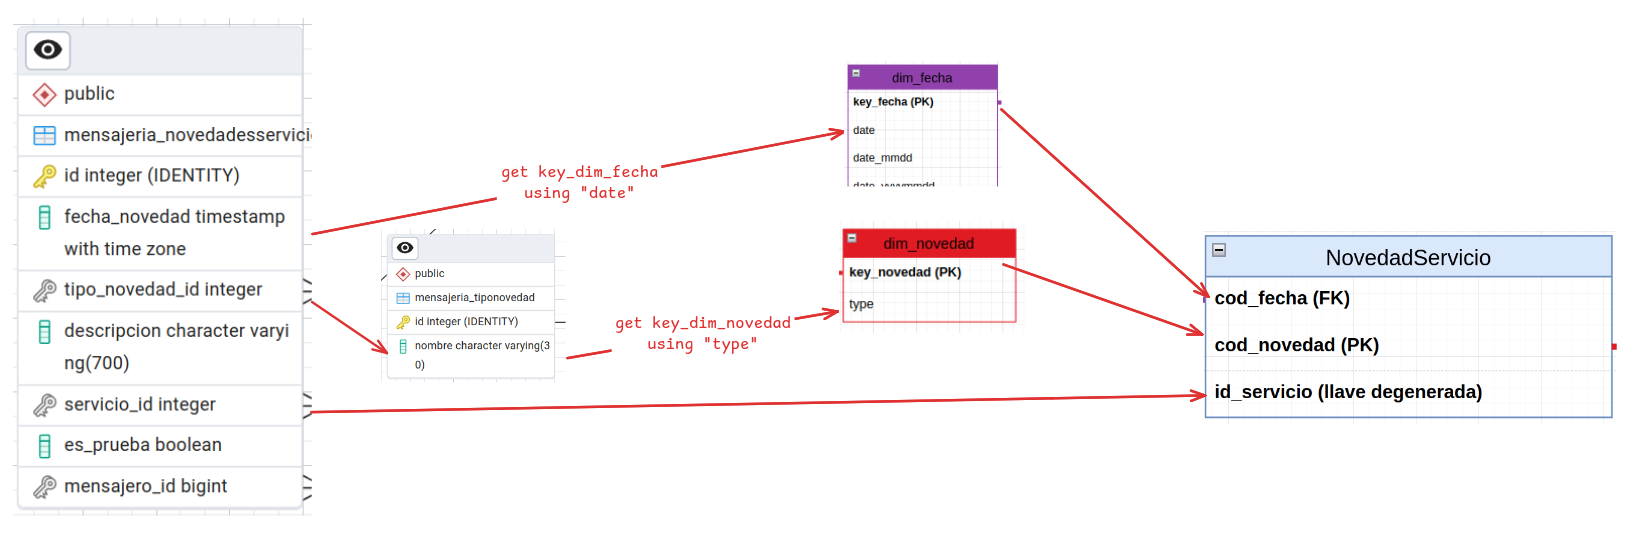

## Importar librerías

In [1]:
import pandas as pd
import sqlalchemy as sa
import utils.conn_tools as ct
from datetime import datetime, timedelta, time
import numpy as np

## Conexión con base de datos

In [2]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

### Asimilación de dimensiones

In [3]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

## Extract

In [4]:
# Leer los datos de las tablas

# De la fuente
msj_tiponovedad = pd.read_sql_table("mensajeria_tiponovedad", con=engine_src)
msj_novedadesservicio = pd.read_sql_table("mensajeria_novedadesservicio", con=engine_src)

# Del Warehouse
dim_fecha = pd.read_sql_table("dim_fecha", con=engine_etl)
dim_novedad = pd.read_sql_table("dim_novedad", con=engine_etl) 

## Transform: Ajustes de la dimensión

In [5]:
# Copia los datos necesarios en el DataFrame
novedadesservicio_df = msj_novedadesservicio[
    [
        "fecha_novedad",
        "tipo_novedad_id",
        "servicio_id",
    ]
].copy()

novedadesservicio_df["fecha_novedad"] = pd.to_datetime(
    novedadesservicio_df["fecha_novedad"]
).dt.date

novedadesservicio_df.head(3)

,fecha_novedad,tipo_novedad_id,servicio_id
0,2023-11-30,1,51
1,2023-11-30,1,51
2,2023-11-30,1,51


### Realizar JOIN con tipo_novedad

In [6]:
# Combinar las tablas para obtener los textos de los estados
merged_df = novedadesservicio_df.merge(
    msj_tiponovedad,
    how="left",
    left_on="tipo_novedad_id",
    right_on="id",
    suffixes=("", "_estado"),
)

merged_df = merged_df[["servicio_id", "fecha_novedad", "nombre"]]
merged_df.rename(columns={"nombre": "tipo_novedad"}, inplace=True)

merged_df.head(3)

,servicio_id,fecha_novedad,tipo_novedad
0,51,2023-11-30,Novedades del servicio
1,51,2023-11-30,Novedades del servicio
2,51,2023-11-30,Novedades del servicio


In [7]:
# Asegurar que el campo de fecha esté en el mismo formato
merged_df["fecha_novedad"] = pd.to_datetime(merged_df["fecha_novedad"], errors="coerce")

# Combina con dim_fecha
merged_df = merged_df.merge(
    dim_fecha,
    how="left",
    left_on="fecha_novedad",
    right_on="date",
    suffixes=("", "_hora"),
)

# Nos quedamos solo con los campos de fecha relevantes
merged_df = merged_df[["servicio_id", "key_fecha", "tipo_novedad"]]

merged_df.head(3)

,servicio_id,key_fecha,tipo_novedad
0,51,334,Novedades del servicio
1,51,334,Novedades del servicio
2,51,334,Novedades del servicio


In [8]:
# Combina con dim_novedad
merged_df = merged_df.merge(
    dim_novedad,
    how="left",
    left_on="tipo_novedad",
    right_on="type",
    suffixes=("", "_hora"),
)

# Nos quedamos solo con los campos de fecha relevantes
merged_df = merged_df[["servicio_id", "key_fecha", "key_novedad"]]

merged_df.head(3)

,servicio_id,key_fecha,key_novedad
0,51,334,1
1,51,334,1
2,51,334,1


In [9]:
hecho_novedad_servicio = merged_df
hecho_novedad_servicio.rename(columns={"servicio_id": "service_id"}, inplace=True)

hecho_novedad_servicio.head(3)

,service_id,key_fecha,key_novedad
0,51,334,1
1,51,334,1
2,51,334,1


In [10]:
# Create table
hecho_novedad_servicio_table = sa.Table(
    "hecho_novedad_servicio",
    metadata,
    # Primary key
    sa.Column("key_hecho_novedad_servicio", sa.Integer, primary_key=True, autoincrement=True, ),
    # Service old id backup
    sa.Column("service_id", sa.Integer, nullable=False),
    sa.Column("key_fecha", sa.Integer, sa.ForeignKey("dim_fecha.key_fecha")),
    sa.Column("key_novedad", sa.Integer, sa.ForeignKey("dim_novedad.key_novedad")),
)

metadata.create_all(engine_etl)

## Load: Ejecución de ETL

In [11]:
hecho_novedad_servicio.to_sql(
    name="hecho_novedad_servicio",
    con=engine_etl,
    if_exists="append",
    index=False,
)

208